# Crowded Trades: Implications for Sector Rotation and Factor Timing 
### William Kinlaw, Mark Kritzman, and David Turkington

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from iex_data import IEX
import matplotlib.pyplot as plt
% matplotlib inline

##### GICS Sector - SPDR ETF
* Energy - XLE
* Materials - XLB  
* Industrials - XLI
* Consumer Discretionary - XLY 
* Consumer Staples - XLP
* Health Care - XLV
* Financials - XLF
* Information Technology - XLK
* Communication Services - XLC *XTL
* Utilities - XLU
* Real Estate - XLRE

In [6]:
# Daily closing prices of sector ETFs 
sectors = IEX()
symbols = ['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']
df_sectors = sectors.price_get(range='5y', symbols=symbols)
# Calculate daily returns and drop NaNs
df_sectors = df_sectors.pct_change()
df_sectors.dropna(inplace=True)

# Standardize the data and calculate covariance matrix
scaler = StandardScaler()
df_sectors_scaled = scaler.fit_transform(df_sectors)
df_sector_cov = np.cov(df_sectors_scaled.T)

df_sectors.head(10)

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
2015-10-09,-0.000452,0.003385,0.001160,0.002231,-0.006485,0.004550,-0.006414,0.004358,0.002680,-0.004773,-0.001652
2015-10-12,-0.008608,0.000186,0.004761,0.002628,-0.012910,0.002631,0.000862,0.001205,-0.002761,0.008905,0.006294
2015-10-13,-0.003883,-0.010677,-0.005379,-0.006050,-0.010433,-0.012534,-0.007738,-0.002166,-0.007770,-0.002263,-0.006255
2015-10-14,0.008026,-0.010790,-0.010171,-0.011564,0.008613,-0.001918,-0.008235,-0.001931,-0.004333,-0.000226,0.000000
2015-10-15,0.002730,0.010908,0.013007,0.009031,0.017962,0.022327,0.022715,0.012813,0.016286,0.014749,-0.002984
2015-10-16,0.000455,-0.005111,0.005264,0.009559,0.001301,0.008968,0.005983,0.001911,-0.000710,0.001341,0.019022
2015-10-19,-0.007032,0.001332,0.004725,0.004434,-0.019789,0.003584,-0.000850,0.003811,-0.004987,0.000671,0.011680
2015-10-20,0.001600,0.006651,-0.001271,-0.000602,0.002800,-0.015712,0.005953,-0.002610,0.012346,0.003348,0.000969
2015-10-21,-0.008896,0.000190,-0.004454,0.000202,-0.012343,-0.008998,-0.007184,-0.007616,-0.015064,-0.002002,0.000808
2015-10-22,0.027382,0.027935,0.013169,0.019867,0.018003,-0.006003,0.016170,0.022543,0.018884,0.011588,0.012637


#### Step 1: Calculate Asset Centrality

## Absorbtion Ratio $$AR = \frac{\sum_{i=1}^n \sigma^2E_i}{\sum_{j=1}^N \sigma^2A_j}$$

- $N$ = number of sectors
- $n$ = number of eigenvectors
- $\sigma^2E_i$ = variance of the $i^{th}$ eigenvector
- $\sigma^2A_j$ = variance of the $j^{th}$ sector

The fraction of the total variance that is "absorbed"/explained by a fixed number of eigenvectors

In [7]:
# AR calculation using PCA
n = 2
sectors_pca = PCA(n_components=n)
sectors_pca.fit(df_sectors_scaled)
ar_pca = np.sum(sectors_pca.explained_variance_ratio_)
print(f'The percent of explained variance in the first {n} principal components = {ar_pca}')

# AR calculation using eigen decompostion of covariance matrix
w, v = np.linalg.eig(df_sector_cov)
sorted_eigenvalues = w.argsort()[::-1]
var_ratio = [eig/np.sum(w) for eig in w[sorted_eigenvalues]]
print(f'The percent of explained variance in the first {n} eigen vectors = {np.sum(var_ratio[0:2])}')

# AR calculation using eigen values and sum of variances of original data
ar_num = np.sum(w[sorted_eigenvalues][0:n])
ar_denom = np.sum(np.var(df_sectors_scaled, axis=0))
ar = ar_num/ar_denom
print(f'The absorbtion ratio of the first {n} eigen vectors over original X variance = {ar}')

The percent of explained variance in the first 2 principal components = 0.720584609984108
The percent of explained variance in the first 2 eigen vectors = 0.7205846099841092
The absorbtion ratio of the first 2 eigen vectors over original X variance = 0.7214644446727345


## Centrality  $$C_i = \frac {\sum_{j=1}^n \biggl( AR^j  \frac{| EV_i^j |}{\sum_{k=1}^N | EV_k^j |} \biggr)}{\sum_{j=1}^n AR^j} $$

- $C_i$ = sector's centrality score
- $AR^j$ = absorbtion ratio of the $j^th$ eigenvector
- $EV_i^j$ = absolute value of the exposure of the $i^th$ sector within the $j^th$ eigenvector
- $n$ = number of eigenvectors in the numerator of the absorbtion ratio
- $N$ = total number of sectors

In [8]:
def centrality_score(X, n=2):
    N = X.shape[1]
    pca_model = PCA(n_components=n)
    pca_model.fit(X)
    EV = pca_model.components_
    AR = pca_model.explained_variance_ratio_
    C_list = []
    for i in range(N):
        C_num = []
        C_denom = []
        for j in range(n):
            C_num.append(AR[j] * \
                    (abs(EV[j][i])/\
                     sum([abs(EV[j][k]) for k in range(N)])))
            C_denom.append(AR[j])
            
        C_list.append(sum(C_num)/sum(C_denom))
    return C_list 

### Sector Market Weights

* Energy - XLE - 5.9%
* Materials - XLB - 2.5%  
* Industrials - XLI - 9.6%
* Consumer Discretionary - XLY - 12.9% 
* Consumer Staples - XLP - 6.7%
* Health Care - XLV - 14.6%
* Financials - XLF - 13.8%
* Information Technology - XLK - 25.6%
* Communication Services - XLC *XTL - 1.9%
* Utilities - XLU - 2.8%
* Real Estate - XLRE - 2.7%


In [9]:
# multiply the returns by the square root of market weights of each sector  
weights = np.array([.025, .096, .129, .067, .069, .146, .138, .256, .019, .028, .027])
sector_weights = dict(zip(df_sectors.columns, weights*100))
weighted_df = df_sectors.copy()
for sector in df_sectors.columns:
    weighted_df.loc[:,sector] = weighted_df.loc[:, sector] * sector_weights[sector]**.5
weighted_df.head()

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
2015-10-09,-0.000715,0.010487,0.004165,0.005774,-0.017036,0.017385,-0.023825,0.022051,0.003694,-0.007986,-0.002715
2015-10-12,-0.013611,0.000577,0.017101,0.006801,-0.033912,0.010051,0.003201,0.006096,-0.003806,0.014900,0.010343
2015-10-13,-0.006139,-0.033080,-0.019319,-0.015659,-0.027405,-0.047893,-0.028746,-0.010958,-0.010711,-0.003786,-0.010278
2015-10-14,0.012691,-0.033431,-0.036531,-0.029932,0.022624,-0.007328,-0.030592,-0.009771,-0.005972,-0.000377,0.000000
2015-10-15,0.004317,0.033796,0.046718,0.023377,0.047184,0.085310,0.084381,0.064831,0.022448,0.024679,-0.004904


In [10]:
print(f'Not scaled - {sorted(zip(symbols, \
[np.around(C,3) for C in centrality_score(df_sectors)]), key=lambda x: x[1], reverse=True)}')

unscaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors)]))

Not scaled - [('XLE', 0.124), ('XLF', 0.106), ('XLB', 0.1), ('XLK', 0.098), ('XLI', 0.093), ('XTL', 0.091), ('XLRE', 0.089), ('XLY', 0.085), ('XLV', 0.078), ('XLP', 0.07), ('XLU', 0.066)]


In [11]:
print(f'Scaled - {sorted(zip(symbols, \
[np.around(C,3) for C in centrality_score(df_sectors_scaled)]), key=lambda x: x[1], reverse=True)}')

scaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors_scaled)]))

Scaled - [('XLP', 0.099), ('XLF', 0.098), ('XLRE', 0.096), ('XLB', 0.095), ('XLY', 0.094), ('XLI', 0.091), ('XLK', 0.091), ('XTL', 0.086), ('XLU', 0.085), ('XLV', 0.083), ('XLE', 0.082)]


In [12]:
print(f'Weighted - {sorted(zip(symbols, \
[np.around(C,3) for C in centrality_score(weighted_df)]), key=lambda x: x[1], reverse=True)}')

weighted_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(weighted_df)]))

Weighted - [('XLK', 0.215), ('XLF', 0.146), ('XLY', 0.117), ('XLE', 0.116), ('XLV', 0.109), ('XLI', 0.108), ('XLB', 0.055), ('XLP', 0.046), ('XTL', 0.044), ('XLRE', 0.03), ('XLU', 0.015)]


In [13]:
# Create a dataframe of scores computed from different methods
for sector in unscaled_scores:
    unscaled_scores[sector] = [unscaled_scores[sector], scaled_scores[sector], weighted_scores[sector]]
scores_df = pd.DataFrame(data=unscaled_scores, index=['Unscaled', 'Scaled', 'Weighted'])
scores_df

,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Unscaled,0.100,0.124,0.106,0.093,0.098,0.070,0.089,0.066,0.078,0.085,0.091
Scaled,0.095,0.082,0.098,0.091,0.091,0.099,0.096,0.085,0.083,0.094,0.086
Weighted,0.055,0.116,0.146,0.108,0.215,0.046,0.030,0.015,0.109,0.117,0.044


In [14]:
# rolling 1-year centrality score 
rolling_Cs = [centrality_score(weighted_df.iloc[i-252:i,:]) for i in range(252, weighted_df.shape[0]+1)]

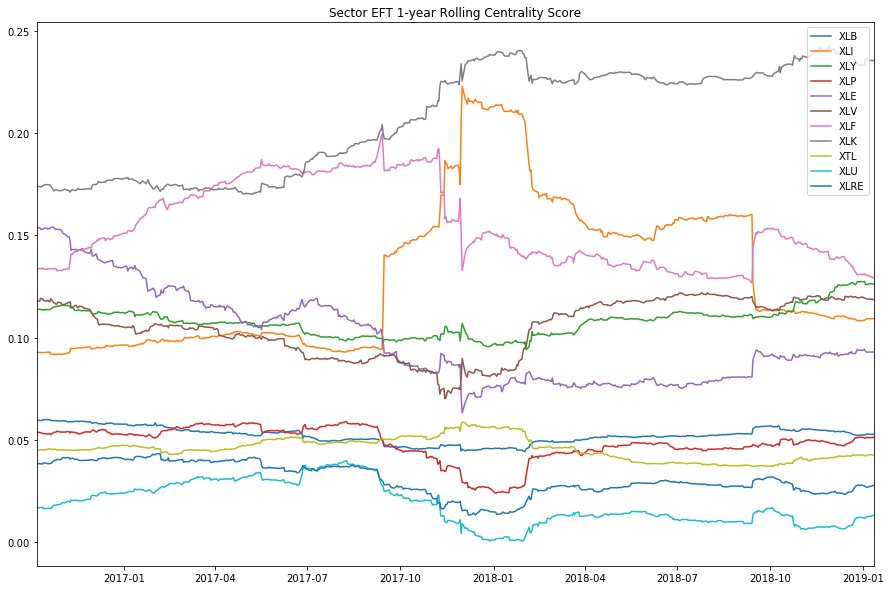

In [15]:
pd.DataFrame(data=rolling_Cs, columns=df_sectors.columns, index=[date.date() for date in df_sectors.index[251:]])\
.plot(figsize=(15,10), title='Sector EFT 1-year Rolling Centrality Score')